# Tutorial: Charsiu -- A transformer-based phonetic aligner



[Jian Zhu](lingjzhu@umich.edu)<sup>1</sup>, [Cong Zhang](cong.zhang@ru.nl)<sup>2</sup>, [David Jurgens](jurgens@umich.edu)<sup>3</sup> 

<sup>1</sup> Department of Linguistics, University of Michigan, Ann Arbor, USA  
<sup>2</sup> Center for Language Studies, Radboud University, Nijmegen, Netherlands  
<sup>3</sup> School of Information, University of Michigan, Ann Arbor, USA 
 
--------

## 1. Introduction
Charsiu is a python-based tool which can align phonemes to the corresponding audio segments. It can force align like a traditional forced aligner (c.f. [1] - [5]); it can also recognize the phonemes first and force align the phonemes without using texts provided by the users.

Charsiu is capable of aligning phonemes using either of the following options:  
 
1.   **textless alignment** with audio files only;
2.   **forced alignment** with audio files and corresponding texts.

**[Running on Colab](#colab)**  
It is generally recommended to use [Colab](https://colab.research.google.com/) to run the tasks, since the *free GPU* speeds up the process by approximately 10 times than using local CPU. If you are not familiar with using Colab, [here](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) is a decent tutorial to get you started.  
  

**[Running locally](#local)**  
However, using Colab service requires the data to be uploaded to Google Drive. 
We understand that for many research projects, data security is a concern. We therefore also offer a tutorial for running the tasks on your local hard drive. 


### 1.1 Models
Charsiu provides a selection of models that you can choose from:     

 

1.   Textless alignment models:    
*   Phone recognizer + Neural Forced Alignment  
> *English (General American)*: `charsiu_chain_attention_aligner(aligner='charsiu/en_w2v2_fs_10ms', recognizer='charsiu/en_w2v2_ctc_libris_and_cv')`


*   Direct inference with frame classification model 
> *English (General American)*: `charsiu_predictive_aligner(aligner='charsiu/en_w2v2_fc_10ms')`  
> *Mandarin Chinese* (small): `charsiu_predictive_aligner(aligner='charsiu/zh_w2v2_tiny_fc_10ms', lang='zh')`  
> *Mandarin Chinese* (large): `charsiu_predictive_aligner(aligner='charsiu/zh_xlsr_fc_10ms', lang='zh')`




2.   Forced alignment models:      

*   Forced alignment with a neural forced alignment model  
> *English (General American)*: `charsiu_forced_aligner(aligner='charsiu/en_w2v2_fc_10ms')`  
> *Mandarin Chinese*: `charsiu_forced_aligner(aligner='charsiu/en_w2v2_fc_10ms', lang="zh")`
*   Forced Alignment with An Attention Alignment Model  
> *English (General American)*: `charsiu_attention_aligner('charsiu/en_w2v2_fs_10ms')`

Detailed information about these models can be found in [Zhu et al. (2021)](https://arxiv.org/pdf/2110.03876.pdf).


### 1.2 Data
For an audio-only task, .wav files are needed. There is no specific requirement about sampling rate or number of channels.   

For a forced alignment task, .wav files with their corresponding texts are needed. You can specify the paths of the audio files and the text files in the code below.








<a name="colab"></a>
## 2. Running on Colab



### 2.1 Installing and importing the libraries
This step is essential for both textless alignment and forced alignment. Run the code block below to install and import the libraries.

In [ ]:
# Step 1: install essential libraries
!pip install torch torchvision torchaudio
!pip install datasets transformers
!pip install praatio librosa
!pip install g2p_en g2pM

     |████████████████████████████████| 298 kB 7.5 MB/s 
     |████████████████████████████████| 3.4 MB 52.3 MB/s 
     |████████████████████████████████| 243 kB 57.0 MB/s 
     |████████████████████████████████| 61 kB 629 kB/s 
     |████████████████████████████████| 1.1 MB 52.6 MB/s 
     |████████████████████████████████| 132 kB 69.8 MB/s 
     |████████████████████████████████| 3.3 MB 39.0 MB/s 
     |████████████████████████████████| 895 kB 45.5 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
     |████████████████████████████████| 192 kB 55.6 MB/s 
     |████████████████████████████████| 160 kB 66.1 MB/s 
     |████████████████████████████████| 271 kB 58.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 3.1 MB 7.4 MB/s 
     |████████████████████████████████| 1.7 M

In [ ]:
# Step 2: download Charsiu library
import os
from os.path import exists, join, expanduser

os.chdir(expanduser("~"))
charsiu_dir = 'charsiu'
if exists(charsiu_dir):
  !rm -rf /root/charsiu
if not exists(charsiu_dir):
  ! git clone -b development https://github.com/lingjzhu/$charsiu_dir
  ! cd charsiu && git checkout && cd -
  
os.chdir(charsiu_dir)    

Cloning into 'charsiu'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (412/412), done.
remote: Compressing objects: 100% (341/341), done.
remote: Total 412 (delta 211), reused 178 (delta 64), pack-reused 0
Receiving objects: 100% (412/412), 1023.33 KiB | 4.85 MiB/s, done.
Resolving deltas: 100% (211/211), done.
Your branch is up to date with 'origin/development'.
/root


In [ ]:
# Step 3: import essential libraries
import sys
import torch
from itertools import groupby

sys.path.insert(0,'src')


If you would like to use your own files, you need to save the audio and text files in a folder called 'Colab Notebooks' in your Google Drive. Then run the following code block.


In [ ]:
# [optional step:] use your own data from your google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<a name="textless"></a>
### 2.2 Textless alignment
This option is suitable for when you DO NOT have the text transcriptions of the audio files. Skip this code block if you would like to perform a forced alignment task with given audio files and their corresponding text transcription files.


In [ ]:
# Step 1: import selected model from Charsiu and initialize model

from Charsiu import charsiu_predictive_aligner
# initialize model
# charsiu = charsiu_predictive_aligner(aligner='charsiu/en_w2v2_fc_10ms')   # a small model with lower accuracy
charsiu = charsiu_predictive_aligner(aligner='charsiu/zh_xlsr_fc_10ms')     # a much larger model with higher accuracy

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/403 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [ ]:
# Step 2: perform textless alignment

## replace the audio path with the path for your own audio file.
alignment = charsiu.align(audio='./local/SA1.WAV')
## print (start_time, end_time, 'segment_label')
print(alignment)

# OR, you can perform textless alignment and output the results directly to a textgrid file
charsiu.serve(audio='./local/SA1.WAV', save_to='./local/SA1.TextGrid')

[(0.0, 0.12, 'NG'), (0.12, 0.43, '[UNK]'), (0.43, 0.55, 'AW'), (0.55, 0.62, 'G'), (0.62, 0.75, '[UNK]'), (0.75, 0.85, 'G'), (0.85, 1.02, '[UNK]'), (1.02, 1.06, 'NG'), (1.06, 1.32, '[UNK]'), (1.32, 1.42, 'NG'), (1.42, 1.44, 'G'), (1.44, 1.54, '[UNK]'), (1.54, 1.6, 'NG'), (1.6, 2.56, '[UNK]'), (2.56, 2.62, 'G'), (2.62, 2.67, 'D'), (2.67, 2.73, '[UNK]'), (2.73, 2.77, 'NG'), (2.77, 2.97, 'EH'), (2.97, 3.36, '[UNK]'), (3.36, 3.47, 'NG')]
Alignment output has been saved to ./local/SA1.TextGrid


<a name="forced"></a>
### 2.3 Forced alignment
This option is suitable for when you have the text transcriptions of your audio files. 

In [ ]:
# Step 1: import selected model from Charsiu
from Charsiu import charsiu_forced_aligner

# initialize model
charsiu = charsiu_forced_aligner(aligner='charsiu/en_w2v2_fc_10ms')

In [ ]:
# Step 2: perform forced alignment
alignment = charsiu.align(audio='./local/SA1.WAV',text='She had your dark suit in greasy wash water all year.')
print(alignment)

# OR, perform forced alignment and save the output as a textgrid file
charsiu.serve(audio='./local/SA1.WAV',text='She had your dark suit in greasy wash water all year.',
              save_to='./local/SA1.TextGrid')

### 2.4 More examples

In [ ]:
# [optional step:] use your own data from your google drive
from google.colab import drive
drive.mount('/content/drive/')

in_wav_dir = "/content/drive/MyDrive/test/"
in_tg_dir = "/content/drive/MyDrive/test/"
in_txt_dir = "/content/drive/MyDrive/test/"
out_tg_dir = "/content/drive/MyDrive/test/"

In [ ]:
# if your sampling rate is not 16k, convert your files first. This step will not be needed after model update.

# !pip install soundfile
import soundfile as sf
import librosa

charsiu = charsiu_predictive_aligner(aligner='charsiu/zh_w2v2_tiny_fc_10ms',lang='zh')
audio, sr = librosa.core.load(in_wav_dir + 'test.wav', sr=16000)

sf.write(in_wav_dir + 'test.wav', audio, sr)


In [ ]:
## resample all wavs in a folder
def resample(input_dir, output_dir):
  if os.path.isdir(input_dir):
        for root, dirs, files in os.walk(input_dir):
            break
        for file in files:
            if file.endswith('.wav'):
              audio, sr = librosa.core.load(input_dir + file, sr=16000)
              sf.write(output_dir + file, audio, sr)

input_dir = in_wav_dir 
output_dir = out_tg_dir
resample(input_dir, output_dir)

In [ ]:
# Charsiu works the best when your files are shorter than 15 ms. Test whether your files are longer than 15ms
## check the duration of all wavs in a folder
def wav_dur(input_dir):
  if os.path.isdir(input_dir):
        for root, dirs, files in os.walk(input_dir):
            break
        for file in files:
            if file.endswith('.wav'):
              dur = librosa.get_duration(filename = input_dir + file)
              if dur >= 15:
                print(f'{file} is over 15 ms. The program will crash if you use this file.')
              elif dur >= 10 and dur < 15:
                print(f'{file} is not idea. It works the best when audio files are around 10 ms.')
              # return dur

input_dir = in_wav_dir
wav_dur(input_dir)


In [ ]:
# Textless alignment: single file, small model
from Charsiu import charsiu_predictive_aligner

charsiu = charsiu_predictive_aligner(aligner='charsiu/zh_w2v2_tiny_fc_10ms',lang='zh')
charsiu.serve(audio = in_wav_dir + 'test.wav', save_to = out_tg_dir + 'test.TextGrid')


In [ ]:
# Textless alignment: single file, large model
from Charsiu import charsiu_predictive_aligner

charsiu = charsiu_predictive_aligner(aligner='charsiu/zh_xlsr_fc_10ms',lang='zh')
charsiu.serve(audio = in_wav_dir + 'test.wav', save_to = out_tg_dir + 'test.TextGrid')

In [ ]:
## Textless alignment: loop through all files in a folder
def textless_alignment_folder(input_dir, output_dir, model, language = "zh"):

  from Charsiu import charsiu_predictive_aligner
  charsiu = charsiu_predictive_aligner(aligner = model, lang = language)

  if os.path.isdir(input_dir):
          for root, dirs, files in os.walk(input_dir):
              break
          for file in files:
              if file.endswith('.wav'):
                charsiu.serve(audio = input_dir + file, save_to = output_dir + file[:-4] + '.TextGrid')



input_dir = in_wav_dir
output_dir = out_tg_dir
model = "charsiu/zh_xlsr_fc_10ms"
textless_alignment_folder(input_dir, output_dir, model)


In [ ]:
# forced alignment: single file
from Charsiu import charsiu_forced_aligner

charsiu = charsiu_forced_aligner(aligner='charsiu/zh_w2v2_tiny_fc_10ms',lang='zh')
charsiu.serve(audio = in_wav_dir + 'test.wav', text = "卡尔普陪外孙玩滑梯。", save_to = out_tg_dir + 'test.TextGrid')

In [ ]:
## forced alignment: loop through all files in a folder
def forced_alignment_folder(input_dir, output_dir, text_dir, model = 'charsiu/zh_w2v2_tiny_fc_10ms', language = "zh"):

  from Charsiu import charsiu_forced_aligner
  charsiu = charsiu_forced_aligner(aligner = model, lang = language)

  if os.path.isdir(input_dir):
          for root, dirs, files in os.walk(input_dir):
              break
          for file in files:
              if file.endswith('.wav'):
                with open(text_dir + file[:-4] + '.txt', 'r', encoding='utf-8') as f:
                  text = f.read()
                  charsiu.serve(audio = input_dir + file, text = text, save_to = output_dir + file[:-4] + '.TextGrid')



input_dir = in_wav_dir
output_dir = out_tg_dir
text_dir = in_txt_dir
forced_alignment_folder(input_dir, output_dir, text_dir)



<a name="local"></a>
## 3. Running locally

You can run it using any IDE of your choice. `Pycharm` is used as an example in this tutorial.





### 3.1 Libraries and Versions

The Python version needs to be
`Python 3.7.*` or above   
(If you have lower version, `praatio 5.x` will not work. All textgrid related procedures will be affected.)

The following libraries are needed:  

*   pytorch  
*   torchvision 
*   torchaudio
*   transformers  
*   librosa  
*   g2p_en
*   g2pM
*   praatio (!important! praatio 5.x is needed for the textgrid functions to run)  

or copy the following code to install all packages:  
`pip install torch torchvision torchaudio transformers g2p_en g2pM praatio librosa`

You also need to download the Charsiu package from [here](https://github.com/lingjzhu/charsiu/archive/refs/heads/main.zip).  
Unzip the file and save it somewhere you can find later on.
You will need to specify its path in the following codes. E.g. `'C:/Users/congzhang/Desktop/charsiu/'`




### 3.2 How to install
Open the `Terminal`, and use 

`pip install package_name`

e.g. 

`pip install torch`
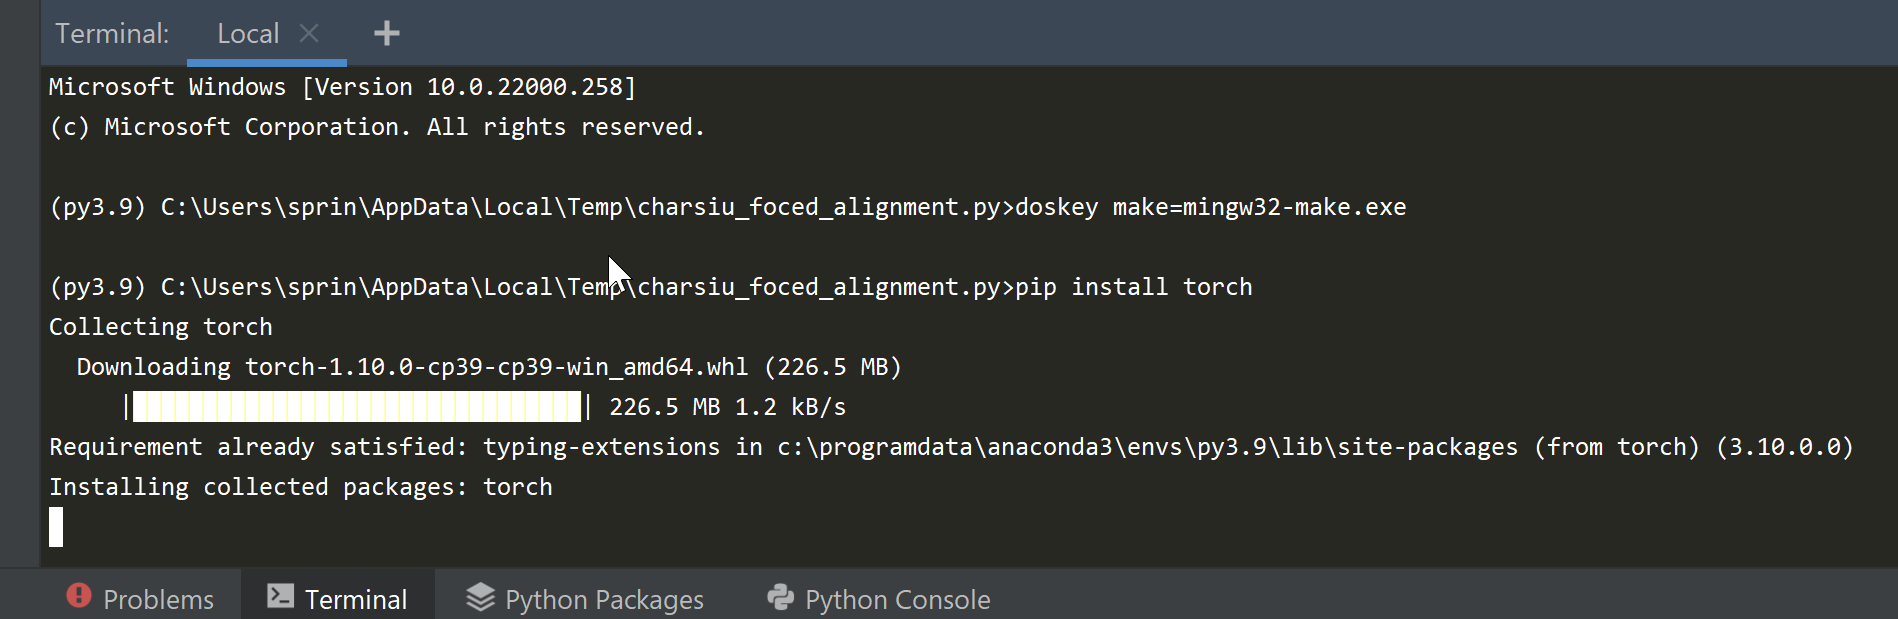




### 3.3 Textless alignment
Below is an example script. You can copy it to your IDE and modify accordingly. Note, you need to specify the paths for:    


*   the charsiu package
*   the audio file
*   the output textgrid file

In [ ]:
# import essential libraries
import os
import sys

# change this path to where you saved the charsiu package
charsiu_dir = 'C:/Users/congzhang/Desktop/charsiu/'
os.chdir(charsiu_dir)

sys.path.append('%s/src/' % charsiu_dir)

# import selected model from Charsiu
from Charsiu import charsiu_predictive_aligner

# initialize model
charsiu = charsiu_predictive_aligner(aligner='charsiu/en_w2v2_fc_10ms')

# load data
## Here are some example paths. Remember to replace with your own paths.
audio_file = 'C:/Users/congzhang/Desktop/DR1_FAKS0_SA1.WAV'
textgrid_file = 'C:/Users/congzhang/Desktop/DR1_FAKS0_SA1.TextGrid'

# perform textless alignment
## replace the audio path with the path for your own audio file.
alignment = charsiu.align(audio=audio_file)
## print (start_time, end_time, 'segment_label')
print(alignment)

# OR, you can perform textless alignment and output the results directly to a textgrid file
charsiu.serve(audio=audio_file, save_to=textgrid_file)


You then get a TextGrid file as shown below:  
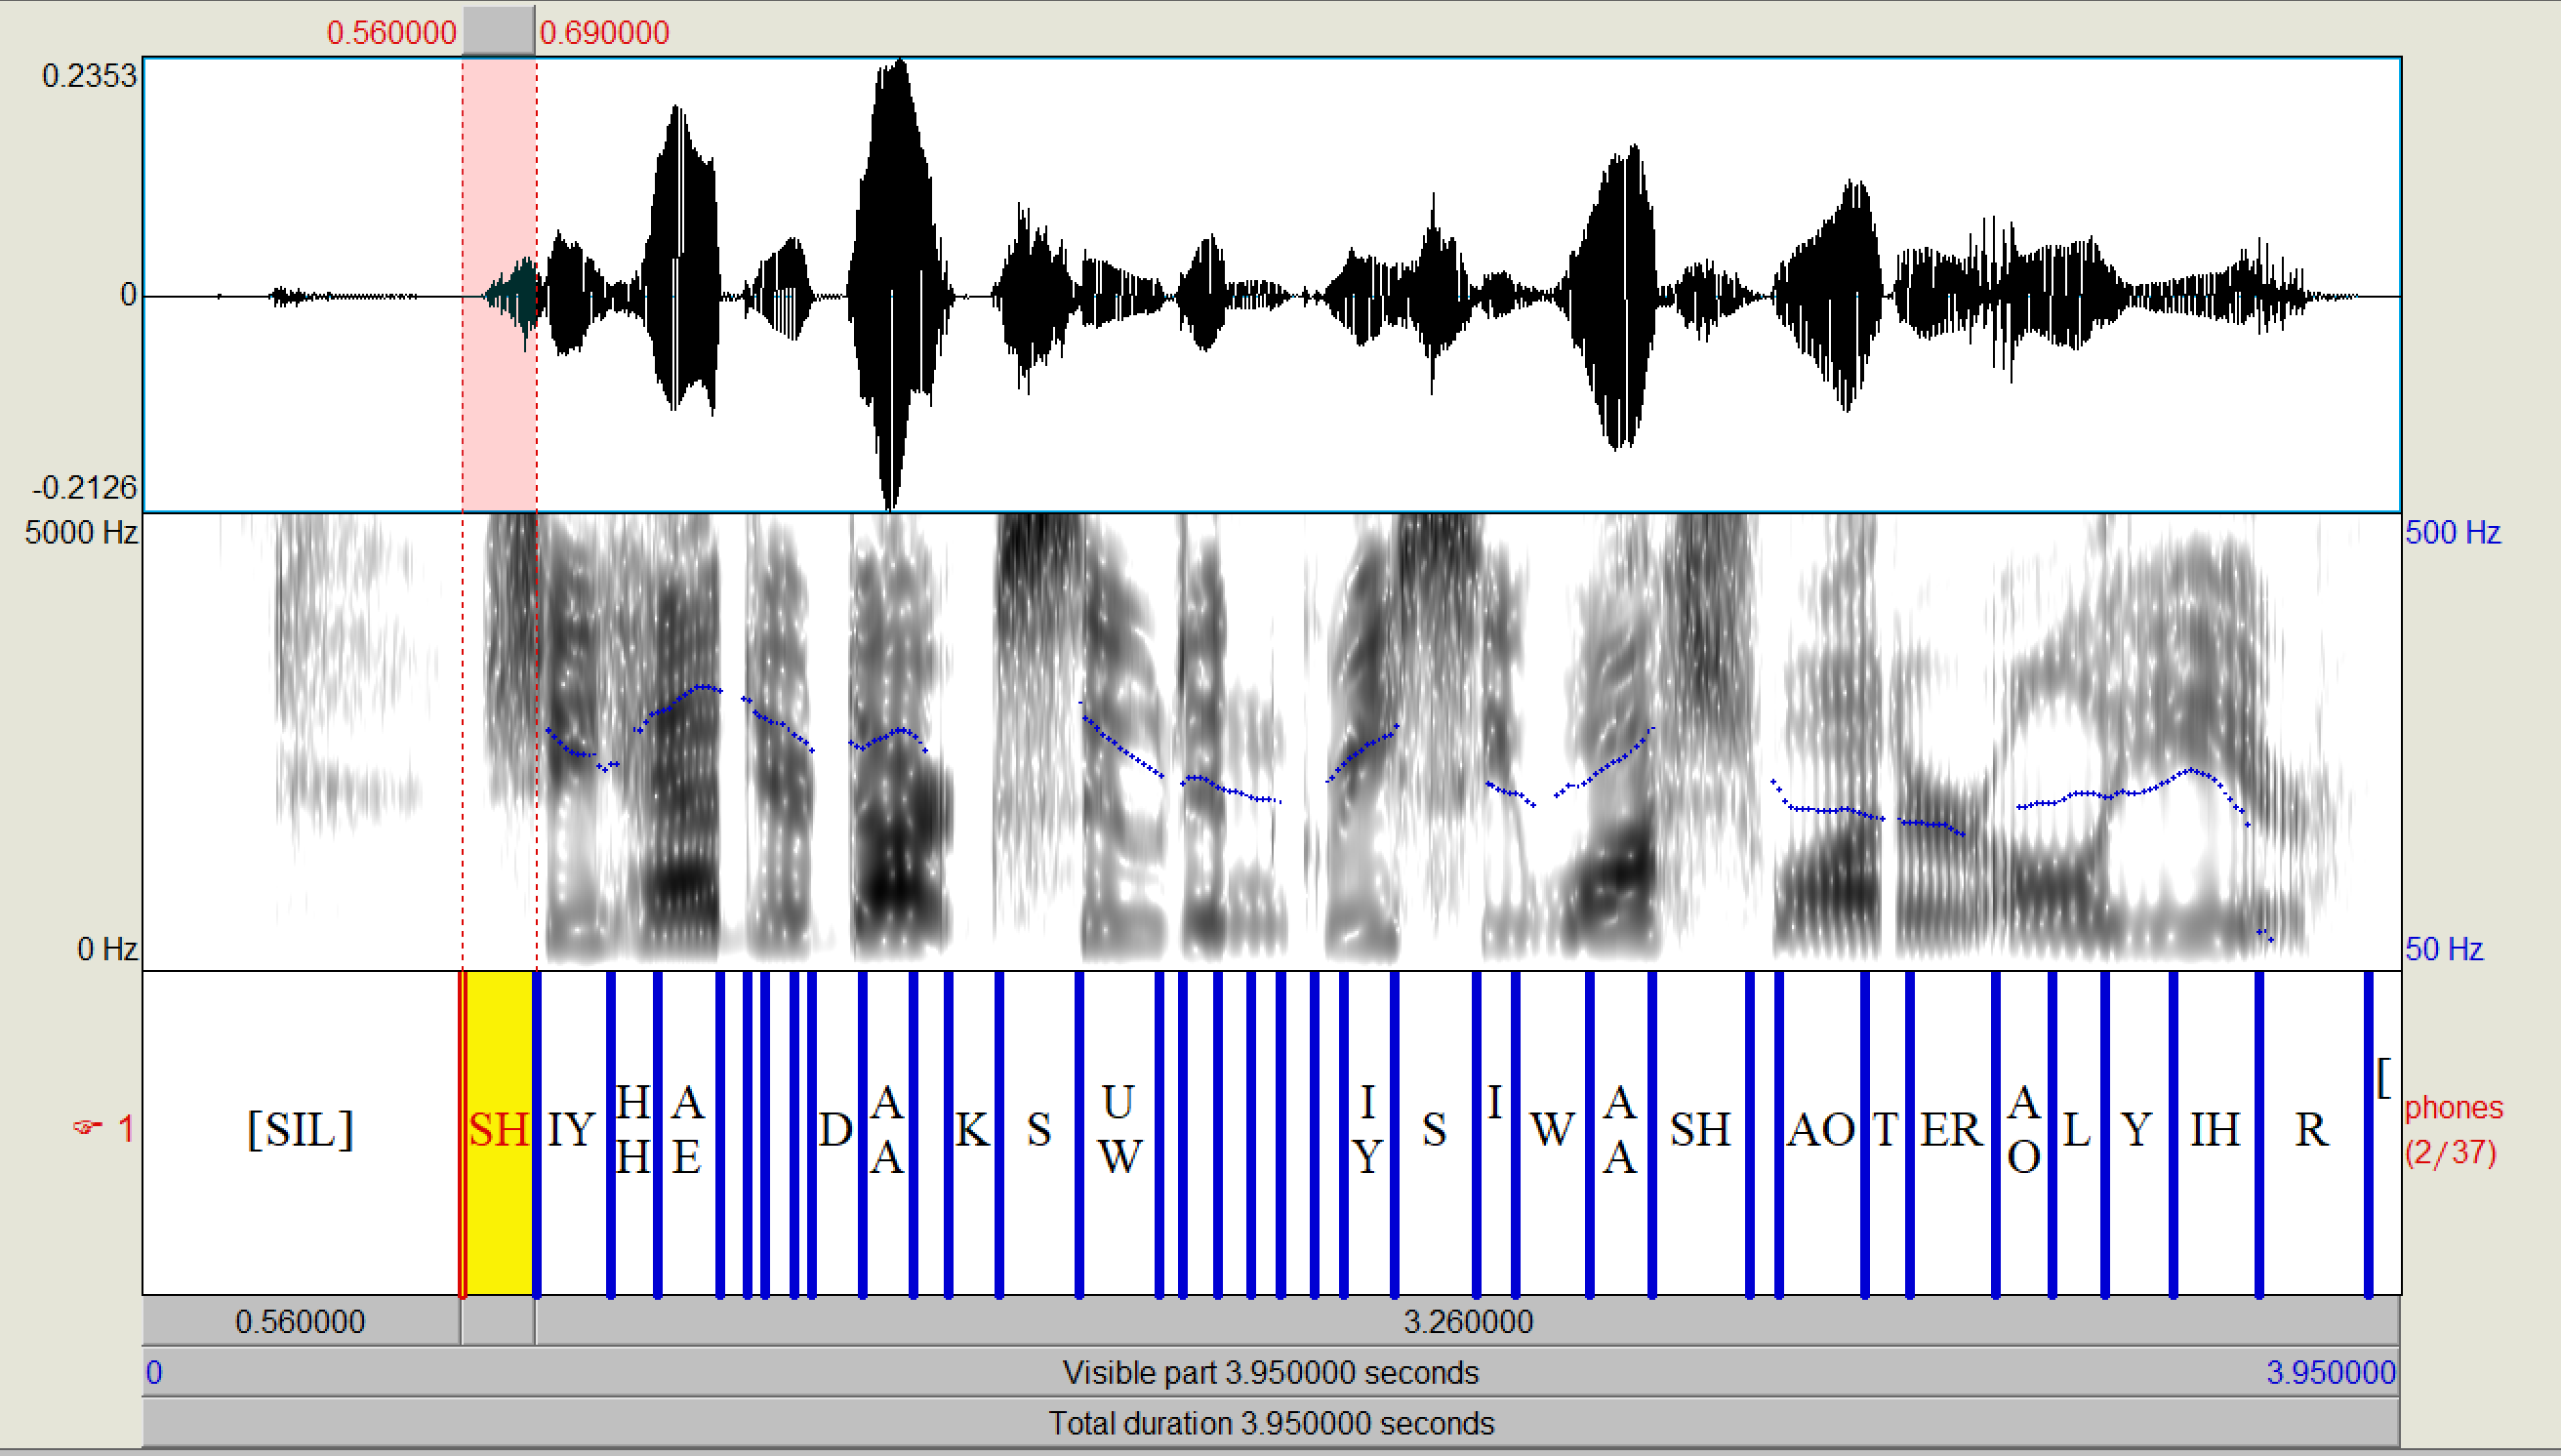

### 3.4 Forced alignment
Below is an example script. You can copy it to your IDE and modify accordingly. Note, you need to specify the paths for:    


*   the charsiu package
*   the audio file
*   the correpsonding text file
*   the output textgrid file

In [ ]:
# import essential libraries
import os
import sys

# change this path to where you saved the charsiu package
charsiu_dir = 'C:/Users/congzhang/Desktop/charsiu/'
os.chdir(charsiu_dir)

sys.path.append('%s/src/' % charsiu_dir)

# import selected model from Charsiu
from Charsiu import charsiu_predictive_aligner

# initialize model
charsiu = charsiu_predictive_aligner(aligner='charsiu/en_w2v2_fc_10ms')

# load data
audio_file = 'C:/Users/congzhang/Desktop/DR1_FAKS0_SA1.WAV'
txt_file = 'C:/Users/congzhang/Desktop/DR1_FAKS0_SA1.txt'
textgrid_file = 'C:/Users/congzhang/Desktop/DR1_FAKS0_SA1.TextGrid'

# import selected model from Charsiu
from Charsiu import charsiu_forced_aligner

# initialize model
charsiu = charsiu_forced_aligner(aligner='charsiu/en_w2v2_fc_10ms')

# read in text file
with open(txt_file) as f:
    text = f.read()

# perform forced alignment
alignment = charsiu.align(audio=audio_file,text=text)

# perform forced alignment and save the output as a textgrid file
charsiu.serve(audio=audio_file, text=text,
              save_to=textgrid_file)


## 4. References 
**Charsiu**:     
J. Zhu et al., "Phone-to-audio alignment without text: A Semi-supervised Approach,", 2021, arXiv:https://arxiv.org/abs/2110.03876.   
Available: https://github.com/lingjzhu/charsiu/.

      
**Other forced aligners**:  
[1] M. McAuliffe et al., “Montreal forced aligner: Trainable text-speech alignment using kaldi.,” in *INTERSPEECH*, 2017. Available: https://montreal-forced-aligner.readthedocs.io/en/latest/index.html.    
[2] K. Gorman et al., “Prosodylab-aligner: A tool for forced alignment of laboratory speech,” *Canadian Acoustics*, 2011. Available: https://prosodylab.org/.  
[3] I. Rosenfelder et al., “FAVE (forced alignment and vowel extraction) program suite,” 2011. Available: http://fave.ling.upenn.edu.   
[4] T. Kisler et al., “Multilingual processing of speech via web services,” *Computer Speech & Language*, 2017. Available: https://clarin.phonetik.uni-muenchen.de/BASWebServices/interface.    
[5] R. Ochshorn and M. Hawkins, “Gentle,” 2017. Available: https://lowerquality.com/gentle/.

